### Modelling Stock Volatility with Ornstein Uhlenbeck Process

In [2]:
# Import dependencies
import time
import math
import numpy as np
import pandas as pd
import datetime
import scipy as sc
import matplotlib.pyplot as plt
import yfinance as yf
from IPython.display import display, Latex
from statsmodels.graphics.tsaplots import plot_acf

In [3]:
# import data
def get_data(stocks, start, end):
    df = yf.download(stocks, start, end)
    return df

endDate = datetime.datetime.now()
startDate = endDate - datetime.timedelta(days=7000)

stock_prices = get_data('^GSPC', startDate, endDate)
print(startDate)
stock_prices.head()

[*********************100%%**********************]  1 of 1 completed

2005-03-10 13:10:18.783058


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2005-03-10,1207.010010,1211.229980,1201.410034,1209.250000,1209.250000,1604020000
2005-03-11,1209.250000,1213.040039,1198.150024,1200.079956,1200.079956,1449820000
2005-03-14,1200.079956,1206.829956,1199.510010,1206.829956,1206.829956,1437430000
2005-03-15,1206.829956,1210.540039,1197.750000,1197.750000,1197.750000,1513530000
2005-03-16,1197.750000,1197.750000,1185.609985,1188.069946,1188.069946,1653190000


#### Volatility clustering in financial time series
Paper: Volatility Clustering in Financial Markets: Emperical Facts and Agent-Based Models, Rama Cont. 2005

The study of statistical properties of financial time series:

* Excess volatility
* heavy Tails
* Volatility Clustering

As noted by Mandelbrot[1], "large changes tend to be followed by large changes, of either sign, and small changes tend to be followed by small changes." A quantitative manifestation of this fact is that, while returns themselves are uncorrelated, absolute returns or their squares actually display a small positive correlation. This is significant and it slowly decays.

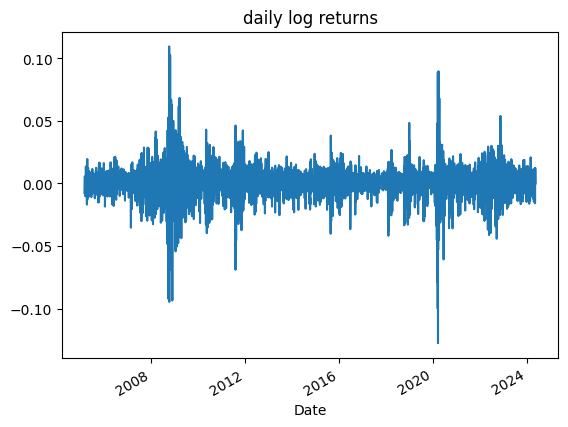

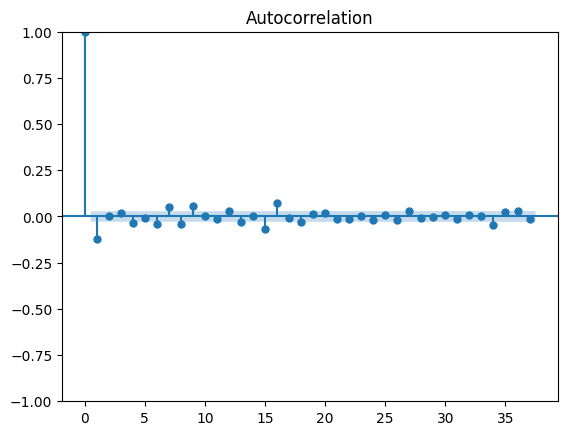

In [4]:
log_returns = np.log(stock_prices.Close/stock_prices.Close.shift(1)).dropna()
log_returns.plot()
plt.title('daily log returns')
plot_acf(log_returns)
plt.show()

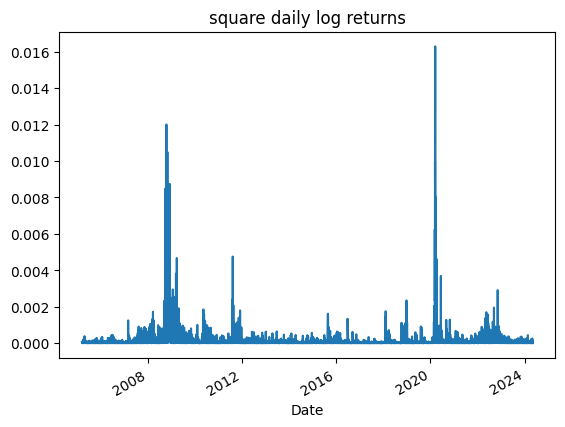

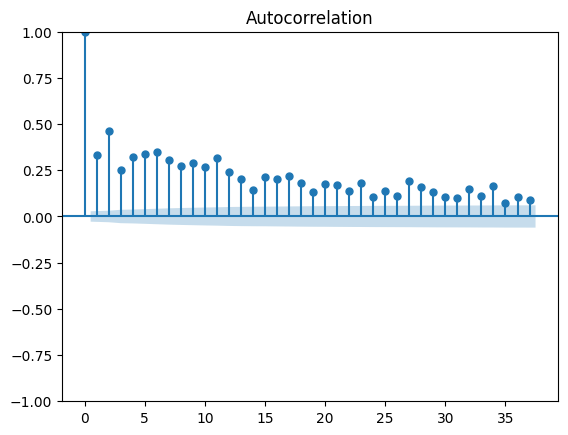

In [5]:
log_returns_sq = np.square(log_returns)
log_returns_sq.plot()
plt.title('square daily log returns')
plot_acf(log_returns_sq)
plt.show()

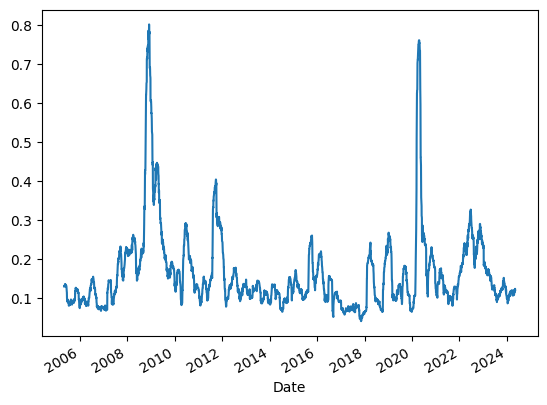

In [6]:
TRADING_DAYS = 40
volatility = log_returns.rolling(window=TRADING_DAYS).std()*np.sqrt(252)
volatility = volatility.dropna()
volatility.plot()
plt.show()

In [7]:
def MLE_norm(x):
    mu_hat = np.mean(x)
    sigma2_hat = np.var(x)
    return mu_hat, sigma2_hat

In [15]:
mu = 5
sigma = 2.5
N = 10000

np.random.seed(0)
x = np.random.normal(loc=mu, scale=sigma, size=(N,))

mu_hat, sigma2_hat = MLE_norm(x)

for_mu_hat = "$\hat{\mu} = "+format(round(mu_hat,2)) + "$"
for_sigma2_hat = "$\hat{\sigma} = "+format(round(np.sqrt(sigma2_hat), 2)) + "$"

print("The MLE for data is: ")
display(Latex(for_mu_hat))
display(Latex(for_sigma2_hat))

The MLE for data is: 


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [16]:
def log_likelihood(theta, x):
    mu = theta[0]
    sigma = theta[1]

    l_theta = np.sum(np.log(sc.stats.norm.pdf(x, loc=mu, scale=sigma)))
    return -l_theta

def sigma_pos(theta):
    sigma = theta[1]
    return sigma

In [18]:
cons_set = {'type': 'ineq', 'fun': sigma_pos}

theta0 = [2,3]

opt = sc.optimize.minimize(fun=log_likelihood ,x0 = theta0, args=(x,), constraints=cons_set)

for_mu_hat = '$\hat{\mu} = '+format(round(opt.x[0],2)) + '$'
for_sigma2_hat = '$\hat{\sigma} = ' + format(round(opt.x[1], 2)) + '$'

print('The MLE for data is:')
display(Latex(for_mu_hat))
display(Latex(for_sigma2_hat))

The MLE for data is:


/tmp/ipykernel_8471/419241023.py:5: RuntimeWarning: divide by zero encountered in log
  l_theta = np.sum(np.log(sc.stats.norm.pdf(x, loc=mu, scale=sigma)))


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

##### Ornstein Uhlenbeck process

In [19]:
def mu(x, dt, kappa, theta):
    ekt = np.exp(-kappa*dt)
    return x*ekt + theta*(1-ekt)

def std(dt, kappa, sigma):
    e2kt = np.exp(-2*kappa*dt)
    return sigma*np.sqrt((1-e2kt)/(2*kappa))

In [20]:
def log_likelihood_OU(theta_hat, x):
    kappa = theta_hat[0]
    theta = theta_hat[1]
    sigma = theta_hat[2]

    x_dt = x[1:]
    x_t = x[:-1]

    dt = 1/252

    mu_OU = mu(x_t, dt, kappa, theta)
    sigma_OU = std(dt, kappa, sigma)

    l_theta_hat = np.sum(np.log(sc.stats.norm.pdf(x_dt, loc=mu_OU, scale=sigma_OU)))

    return -l_theta_hat

def kappa_pos(theta_hat):
    kappa = theta_hat[0]
    return kappa

def sigma_pos(theta_hat):
    sigma = theta_hat[2]
    return sigma

In [21]:
vol = np.array(volatility)

In [22]:
cons_set = [{'type': 'ineq', 'fun': kappa_pos},
            {'type': 'ineq', 'fun': sigma_pos}]

theta0 = [1,1,1]
opt = sc.optimize.minimize(fun=log_likelihood_OU, x0 = theta0, args=(vol,), constraints=cons_set)

opt

/tmp/ipykernel_8471/2964945180.py:14: RuntimeWarning: divide by zero encountered in log
  l_theta_hat = np.sum(np.log(sc.stats.norm.pdf(x_dt, loc=mu_OU, scale=sigma_OU)))


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -17044.317784092727
       x: [ 5.064e-01  1.622e-01  1.090e-01]
     nit: 31
     jac: [ 1.221e-03 -2.686e-03  1.228e-01]
    nfev: 127
    njev: 27

In [ ]:
for_mu_hat = '$\hat{\mu} = '+format(round(opt.x[0],2)) + '$'
for_sigma2_hat = '$\hat{\sigma} = ' + format(round(opt.x[1], 2)) + '$'
for_kappa_hat = '$\hat{\kappa} = ' + format(round(opt.x[1], 2)) + '$'

print('The MLE for data is:')
display(Latex(for_mu_hat))
display(Latex(for_sigma2_hat))